In [1]:
# Deafault Imports
import os
import logging
import functools
import warnings as wr
import numpy as np
import random as rnd
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras as tfk
from keras import layers as tkl
from keras import models as tkm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

!wget https://storage.googleapis.com/storage.barbiero.dev/public_data_clean.npz

--2023-11-09 09:49:48--  https://storage.googleapis.com/storage.barbiero.dev/public_data_clean.npz
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.203.207, 108.177.98.207, 74.125.197.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.203.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 536546306 (512M) [application/octet-stream]
Saving to: ‘public_data_clean.npz’

public_data_clean.n 100%[===================>] 511.69M  26.2MB/s    in 20s     

2023-11-09 09:50:09 (25.8 MB/s) - ‘public_data_clean.npz’ saved [536546306/536546306]



In [13]:
# Random Configuration - All
RND = False
if not RND:
  SEED = 76998669
  os.environ['PYTHONHASHSEED'] = str(SEED)
  tf.compat.v1.set_random_seed(SEED)
  tf.random.set_seed(SEED)
  np.random.seed(SEED)
  rnd.seed(SEED)

# OS Configuration
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

# Warning Congiguration
wr.simplefilter(action='ignore', category=FutureWarning)
wr.simplefilter(action='ignore', category=Warning)

# TensorFlow Configuration
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [14]:
# Plotting Functions
def plot_losses(history, figsize, name_jpg):
  best_epoch = np.argmax(history['val_accuracy'])
  fig, axes = plt.subplots(2,1, figsize=figsize, dpi=200)

  axes[0].plot(history['loss'], label='Training Loss', color='#9859C5', alpha=.8)
  axes[0].plot(history['val_loss'], label='Validation Loss', color='#4D61E2', alpha=.8)
  axes[0].set_title('Loss')
  axes[0].legend()
  axes[0].grid(alpha=.3)

  axes[1].plot(history['accuracy'], label='Training Accuracy', color='#9859C5', alpha=.8)
  axes[1].plot(history['val_accuracy'], label='Validation Accuracy', color='#4D61E2', alpha=.8)
  axes[1].plot(best_epoch, history['val_accuracy'][best_epoch], marker='d', alpha=0.8, markersize=10, color='#4D61E2')
  axes[1].set_title('Accuracy')
  axes[1].legend()
  axes[1].grid(alpha=.3)

  plt.savefig(name_jpg)
  plt.show()

def plot_images(images, labels, index=0, rows=1, cols=1, normalized=False):
  data_rescaling = tkl.Rescaling(scale=1./255)
  if normalized==False:
    IMGS_= data_rescaling(images)
  size = rows*cols
  diff = len(images)-(size+index)
  if diff <= 0:
    size = len(images)-index
    plt.figure(figsize=(cols,rows), dpi=200)
    for i in range(size):
      ax = plt.subplot(rows, cols, i + 1)
      plt.imshow(IMGS_[index + i])
      plt.title(labels[i], fontdict={"fontsize":5}, pad=2)
      plt.axis("off")

#plot_images(IMGS[:25], LBLS[:25], 0, 5, 5)

In [15]:
# Initializate
DATA = np.load('public_data_clean.npz', allow_pickle=True)
KEYS = list(DATA.keys())

IMGS = np.array(DATA[KEYS[0]])
LIMG = len(IMGS)
LBLS = np.array(DATA[KEYS[1]])
LLBL = len(LBLS)

BATCH = 32
TEST_PERC = 0.15
VALI_PERC = 0.15

MPLBL = {0: "healthy", 1: "unhealthy"}
RMLBL = {"healthy": 0, "unhealthy": 1}
LBLS = np.array([RMLBL[l] for l in LBLS])
LBLS = tfk.utils.to_categorical(LBLS, len(np.unique(LBLS)))

print('Images: ', LIMG)
print('Labels: ', LLBL)
print()

# Split the Data Set into Training XT YT, Validation XV YV, Test XTE YTE
Xtrv, XTE, Ytrv, YTE = train_test_split(
    IMGS,
    LBLS,
    test_size=int(TEST_PERC * LIMG),
    **({"random_state":SEED} if not RND else {}),
    stratify=LBLS
)

XT, XV, YT, YV = train_test_split(
    Xtrv,
    Ytrv,
    test_size=int(VALI_PERC*LIMG),
    **({"random_state":SEED} if not RND else {}),
    stratify=Ytrv
)

# Shapes
print('Training Set Shape: ', XT.shape, YT.shape)
print('Validation Set Shape: ', XV.shape, YV.shape)
print('Test Set Shape: ', XTE.shape, YTE.shape)
print()

# Get the Shape of IN OUT
input_shape = XT.shape[1:]
output_shape = YT.shape[1]                                                        # Enable for MultiClass Problem

print(f'Input shape of the Network: {input_shape}')
print(f'Output shape of the Network: {output_shape}')
print()

Images:  4850
Labels:  4850

Training Set Shape:  (3396, 96, 96, 3) (3396, 2)
Validation Set Shape:  (727, 96, 96, 3) (727, 2)
Test Set Shape:  (727, 96, 96, 3) (727, 2)

Input shape of the Network: (96, 96, 3)
Output shape of the Network: 2



In [ ]:
data_rescaling = tkl.Rescaling(scale=1./255)                                      # Normalize the Images from 0..255 to 0..1
data_backscaling = tkl.Rescaling(scale=1.*255)                                    # Normalize the Images from 0..1 to 0..255

data_rescaling_c = tkl.Rescaling(scale=1./127.5, offset=-1)                       # Normalize the Images from 0..255 to -1..1
data_backscaling_c = tkl.Rescaling(scale=1.*127.5, offset=1)                      # Normalize the Images from -1..1 to 0..255

data_alex_augmentation = tkm.Sequential([
  tkl.RandomFlip('horizontal'),
  tkl.RandomRotation(359),
  tkl.RandomBrightness(factor=0.35),
  tkl.RandomContrast(factor=(0,0.9))
])

In [ ]:
from keras.applications.mobilenet_v2 import preprocess_input

def apple_elixir_model(input_shape, output_shape):

  preprocessing = tfk.Sequential([
      tkl.RandomTranslation(height_factor=(-0.3,0.3),width_factor=(-0.3,0.3)),
      tkl.RandomZoom(height_factor=(-0.2,0.2),width_factor=(-0.2,0.2)),
      tkl.RandomFlip('horizontal'),
      tkl.RandomRotation(factor=359)
    ], name='preprocessing'
  )

  # TO CHANGE - res of the Model
  res = tfk.applications.MobileNetV2(
    input_shape=input_shape,
    include_top=False,
    weights="imagenet",
    classes=2,
    classifier_activation='softmax'
  )

  res.trainable = False
  input_layer = tkl.Input(input_shape)
  x = preprocess_input(input_layer)

  x = preprocessing(x)

  x = res(x)
  x = tkl.GlobalAveragePooling2D()(x)

  x = tkl.Dense(units=1024,activation=tkl.LeakyReLU(alpha=0.3))(x)              # maybe we have to use leakyrelu
  # x = tfkl.Dense(units=562,activation='relu')(x)
  # x = tfkl.Dense(units=256,activation='relu')(x)
  # x = tfkl.Dense(units=1024,activation='relu')(x)

  output_layer = tkl.Dense(units=output_shape,activation='softmax')(x)

  model =tfk.Model(input_layer, output_layer)

  # Compile the model
  model.compile(
      loss=tfk.losses.CategoricalCrossentropy(),
      optimizer=tfk.optimizers.Nadam(learning_rate=0.001, weight_decay=0.001),
      metrics=['accuracy']
  )

  return model

model = apple_elixir_model(input_shape,output_shape)


In [ ]:
# Train the model
early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=20,
    mode='max',
    restore_best_weights=True)

lr_scheduler = tfk.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',                         # Metric to monitor (validation mean squared error in this case)
    patience=5,                                     # Number of epochs with no improvement after which learning rate will be reduced
    factor=0.85,                                    # Factor by which the learning rate will be reduced (0.999 in this case)
    mode='max',                                     # Mode to decide when to reduce learning rate ('min' means reduce when metric stops decreasing)
    min_lr=1e-7                                     # Minimum learning rate
)

callbacks = [early_stopping,lr_scheduler]

history = model.fit(
    x = XT,
    y = YT,
    batch_size = 32,
    epochs = 300,
    validation_data = (XV, YV),
    callbacks = callbacks
).history

In [2]:
NAME_MODEL = "MobilNetV2_001"
NAME_PLOT = NAME_MODEL + "_plot"

In [ ]:
plot_losses(history, (20,5), NAME_PLOT)

test_predictions = model.predict(XT, verbose=0)
test_predictions = np.argmax(test_predictions, axis=-1)
test_gt = np.argmax(YT, axis=-1)
test_accuracy = accuracy_score(test_gt, test_predictions)
print(f'Accuracy Score over the Test Set: {round(test_accuracy, 4)}')
print()

In [7]:
ft_model = tfk.models.load_model(NAME_MODEL)

In [8]:
ft_model.get_layer('mobilenetv2_1.00_96').trainable = True
c = 0
for i, layer in enumerate(model.get_layer('mobilenetv2_1.00_96').layers):
   c += 1

print(c)

154


In [9]:
for i, layer in enumerate(ft_model.get_layer('mobilenetv2_1.00_96').layers[:80]):
  layer.trainable=False

ft_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Nadam(learning_rate=0.001, weight_decay=0.001), metrics=['accuracy'])

In [28]:
print(XT[0])

[[[127. 186.  80.]
  [124. 183.  77.]
  [129. 190.  87.]
  ...
  [102. 142.  80.]
  [117. 157.  95.]
  [116. 156.  94.]]

 [[129. 187.  84.]
  [120. 178.  75.]
  [115. 176.  73.]
  ...
  [109. 149.  87.]
  [122. 162. 100.]
  [122. 162. 100.]]

 [[146. 204. 104.]
  [135. 193.  91.]
  [113. 173.  73.]
  ...
  [106. 147.  87.]
  [116. 157.  97.]
  [114. 155.  95.]]

 ...

 [[125. 175.  52.]
  [111. 160.  43.]
  [ 83. 127.  38.]
  ...
  [ 89. 157.  58.]
  [ 86. 153.  56.]
  [ 93. 160.  65.]]

 [[112. 161.  44.]
  [102. 150.  40.]
  [ 42.  86.   1.]
  ...
  [ 84. 151.  58.]
  [ 91. 156.  72.]
  [104. 169.  85.]]

 [[112. 161.  46.]
  [103. 151.  42.]
  [ 29.  73.   0.]
  ...
  [ 81. 147.  57.]
  [ 93. 158.  76.]
  [108. 173.  93.]]]


In [16]:
early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=30,
    mode='max',
    restore_best_weights=True)

lr_scheduler = tfk.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',     # Metric to monitor (validation mean squared error in this case)
    patience=5,  # Number of epochs with no improvement after which learning rate will be reduced
    factor=0.80,          # Factor by which the learning rate will be reduced (0.999 in this case)
    mode='max',            # Mode to decide when to reduce learning rate ('min' means reduce when metric stops decreasing)
    min_lr=1e-7            # Minimum learning rate
)

callbacks = [early_stopping,lr_scheduler]

history = ft_model.fit(
    x = XT, # We need to apply the preprocessing thought for the MobileNetV2 network
    y = YT,
    batch_size = 32,
    epochs = 300,
    validation_data = (XV, YV), # We need to apply the preprocessing thought for the MobileNetV2 network
    callbacks = callbacks
).history

Epoch 1/300
107/107 [==============================] - 56s 84ms/step - loss: 0.5656 - accuracy: 0.7297 - val_loss: 0.5684 - val_accuracy: 0.7469 - lr: 0.0010
Epoch 2/300
107/107 [==============================] - 8s 74ms/step - loss: 0.5002 - accuracy: 0.7659 - val_loss: 0.9187 - val_accuracy: 0.7304 - lr: 0.0010
Epoch 3/300
107/107 [==============================] - 6s 54ms/step - loss: 0.4582 - accuracy: 0.7918 - val_loss: 2.0213 - val_accuracy: 0.6685 - lr: 0.0010
Epoch 4/300
107/107 [==============================] - 7s 65ms/step - loss: 0.4312 - accuracy: 0.8051 - val_loss: 1.5748 - val_accuracy: 0.7497 - lr: 0.0010
Epoch 5/300
107/107 [==============================] - 5s 43ms/step - loss: 0.4178 - accuracy: 0.8198 - val_loss: 1.3254 - val_accuracy: 0.7276 - lr: 0.0010
Epoch 6/300
107/107 [==============================] - 5s 47ms/step - loss: 0.4210 - accuracy: 0.8062 - val_loss: 0.6657 - val_accuracy: 0.8239 - lr: 0.0010
Epoch 7/300
107/107 [==============================] - 5s

In [26]:
FT_NAME = NAME_MODEL+"_Tuning"
FT_PLOT = NAME_PLOT+"_Tuning"
print(FT_NAME, FT_PLOT)

MobilNetV2_001_Tuning MobilNetV2_001_plot_Tuning


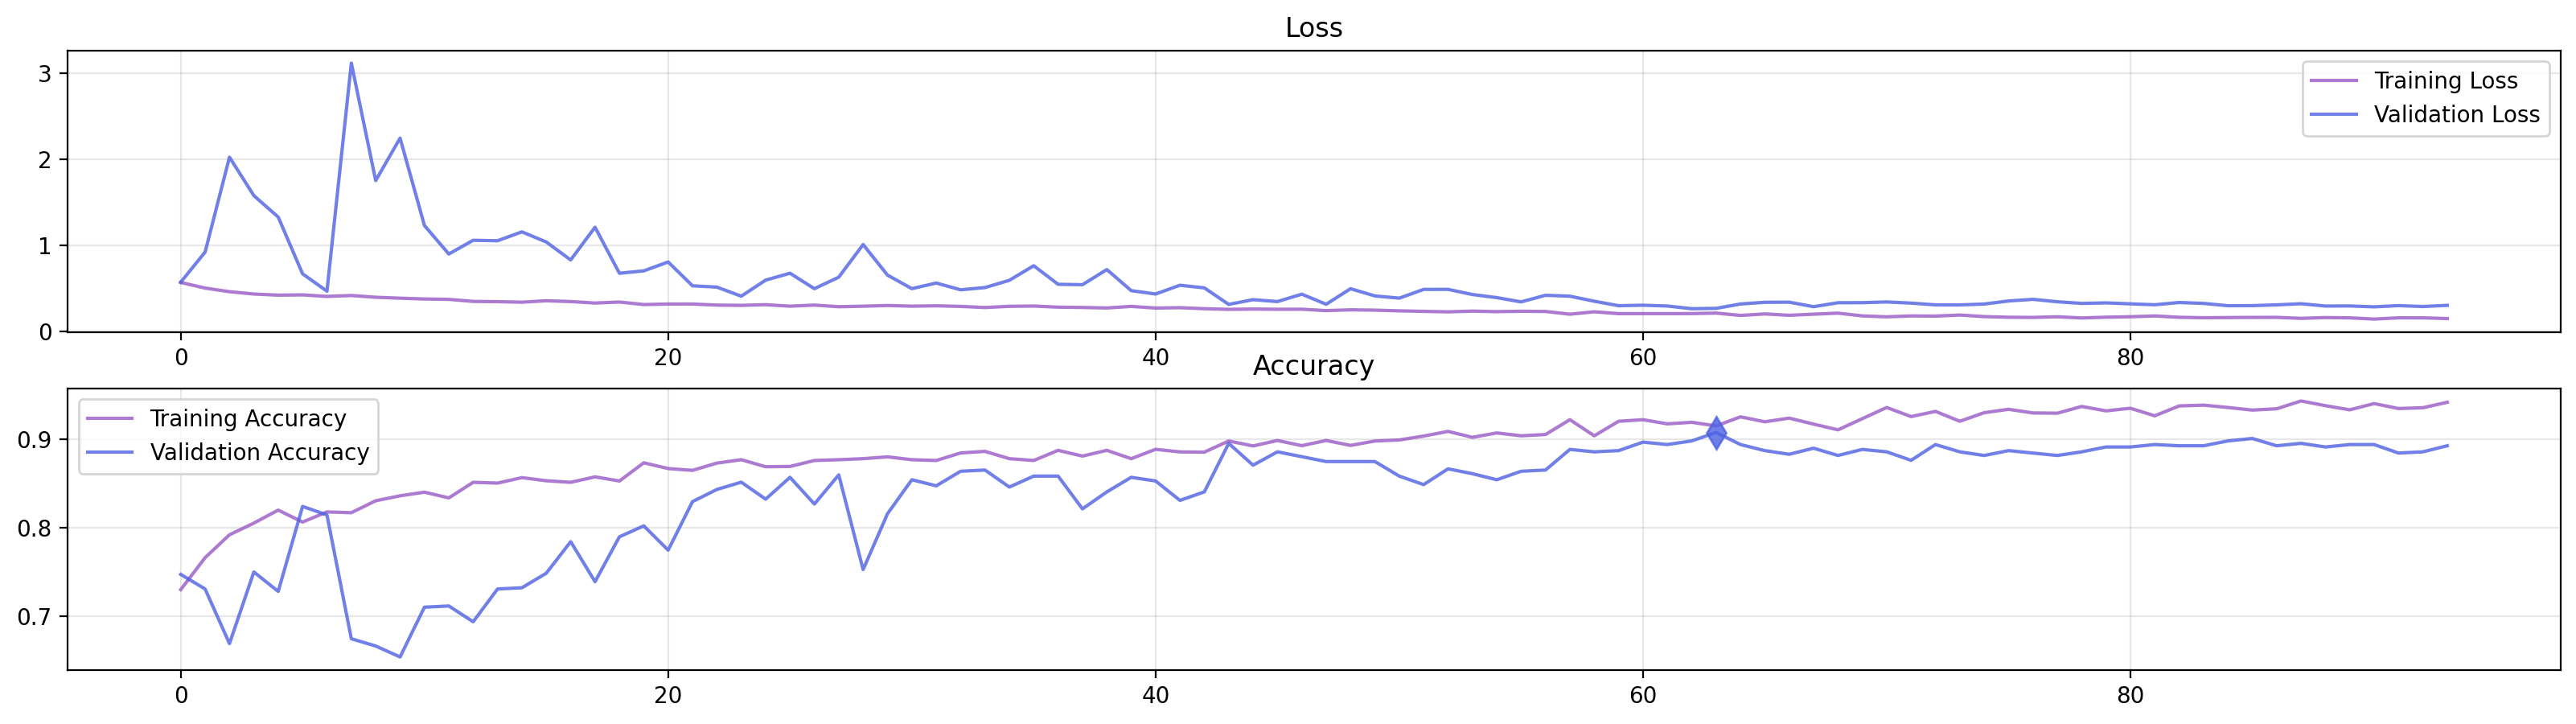

In [17]:
plot_losses(history, (20,5), FT_NAME)

In [21]:
test_predictions = ft_model.predict(XT, verbose=0)
test_predictions = np.argmax(test_predictions, axis=-1)
test_gt = np.argmax(YT, axis=-1)
test_accuracy = accuracy_score(test_gt, test_predictions)
print(f'Accuracy Score over the Test Set: {round(test_accuracy, 4)}')
print()

Accuracy Score over the Test Set: 0.9429



In [23]:
ft_model.save(NAME_MODEL+"_Tuning")

In [27]:
!zip -r {FT_NAME}.zip {FT_NAME} {FT_PLOT}.png

  adding: MobilNetV2_001_Tuning/ (stored 0%)
  adding: MobilNetV2_001_Tuning/assets/ (stored 0%)
  adding: MobilNetV2_001_Tuning/keras_metadata.pb (deflated 96%)
  adding: MobilNetV2_001_Tuning/saved_model.pb (deflated 90%)
  adding: MobilNetV2_001_Tuning/variables/ (stored 0%)
  adding: MobilNetV2_001_Tuning/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: MobilNetV2_001_Tuning/variables/variables.index (deflated 76%)
  adding: MobilNetV2_001_Tuning/fingerprint.pb (stored 0%)
  adding: MobilNetV2_001_plot_Tuning.png (deflated 11%)
